In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split


from scipy import optimize
from scipy.io import loadmat

import numba 
from numba import prange

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from scipy.spatial import procrustes
from matplotlib.colors import ListedColormap


d = loadmat('data/macosko.mat')

X_data = d['X_data']
y_data = d['y_data'].reshape(-1)

print(X_data.shape,y_data)

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.33, random_state=42)

X_train = X_data
y_train = y_data

n = X_train.shape[0]

classes = ['Amacrine cells',
           'Astrocytes',
           'Bipolar cells',
           'Cones',
           'Fibroblasts',
           'Horizontal cells',
           'Microglia',
           'Muller glia',
           'Pericytes',
           'Retinal ganglion cells',
           'Rods',
           'Vascular endothelium']
    
print(X_train.shape, y_train.shape, X_train.dtype)
#print(X_test.shape, y_test.shape, X_test.dtype)

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(44808, 50) [ 9.  9.  9. ...  9. 10. 10.]
(44808, 50) (44808,) float32


/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


<IPython.core.display.Javascript object>


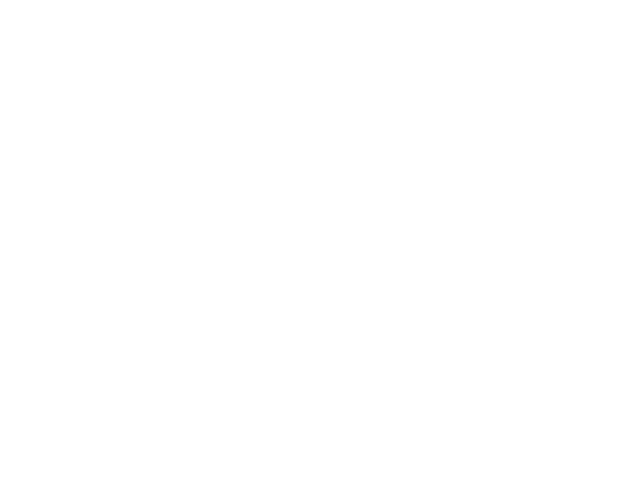

In [2]:
import umap

ump = umap.UMAP(n_neighbors=n_neighbors,
        min_dist=MIN_DIST,
        n_components=n_components,
        random_state=100,
        metric= 'euclidean')

y_umap_mapper = ump.fit(X_train)
y_umap = y_umap_mapper.embedding_

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)


In [17]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>

In [4]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 10000
nB = 17404
nC = 17404

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]
SETB = X_train_rp[nA:nA+nB]
y_SETB = y_train_rp[nA:nA+nB]
SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC = y_train_rp[nA+nB:nA+nB+nC]

data1 = np.concatenate((SETA, SETB))
data2 = np.concatenate((SETA, SETC))


print(SETA.shape, SETB.shape, SETC.shape)

(10000, 50) (17404, 50) (17404, 50)


In [5]:
D1 = np.concatenate((SETA, SETB))
D2 = np.concatenate((SETA, SETC))

slices = [D1, D2]

relation_dict = {i:i for i in range(len(SETA))}
relation_dicts = [relation_dict]
#print(relation_dict)

In [6]:
np.random.seed(100)
aligned_mapper = umap.AlignedUMAP(n_neighbors=n_neighbors,
                                  random_state=42).fit(slices, relations=relation_dicts)

In [7]:
embA = aligned_mapper.embeddings_[0][0:10000]
embB = aligned_mapper.embeddings_[0][10000:]
embA_C = aligned_mapper.embeddings_[1][:10000]
embC = aligned_mapper.embeddings_[1][10000:]

<IPython.core.display.Javascript object>


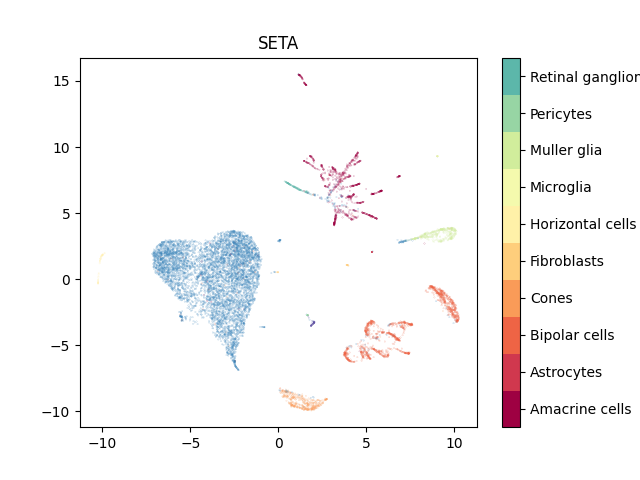

(10000, 2)


<IPython.core.display.Javascript object>


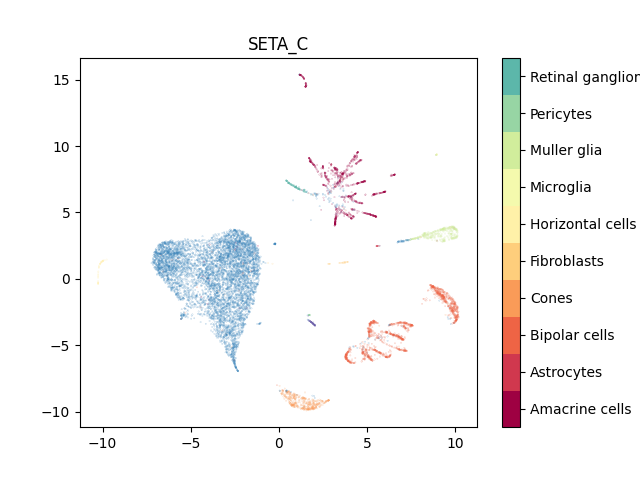

<IPython.core.display.Javascript object>


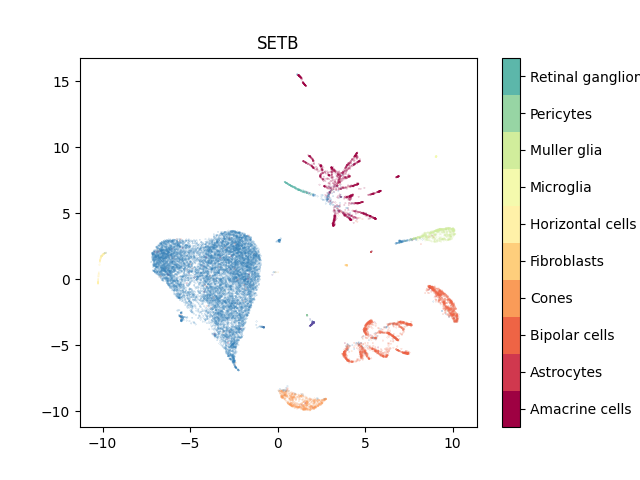

(17404, 2)


<IPython.core.display.Javascript object>


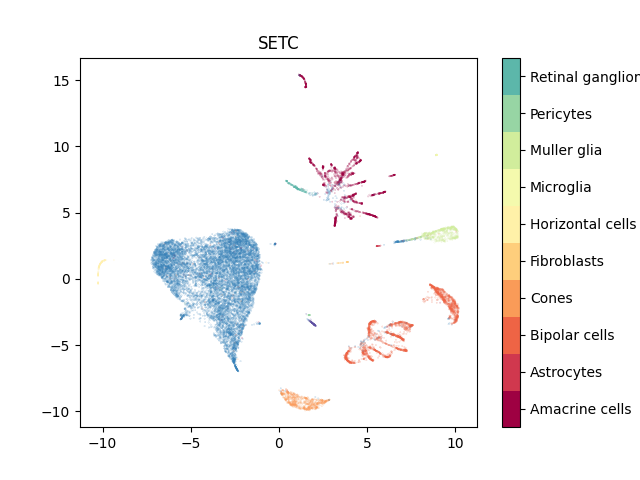

(17404, 2)


In [8]:
%matplotlib notebook

plt.figure()
plt.title('SETA')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plt.figure()
plt.title('SETA_C')
plt.scatter(embA_C[:,0], embA_C[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)


plt.figure()
plt.title('SETB')
print(embB.shape)
plt.scatter(embB[:,0], embB[:,1], c=y_SETB, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plt.figure()
plt.title('SETC')
print(embC.shape)
plt.scatter(embC[:,0], embC[:,1], c=y_SETC, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)


<IPython.core.display.Javascript object>


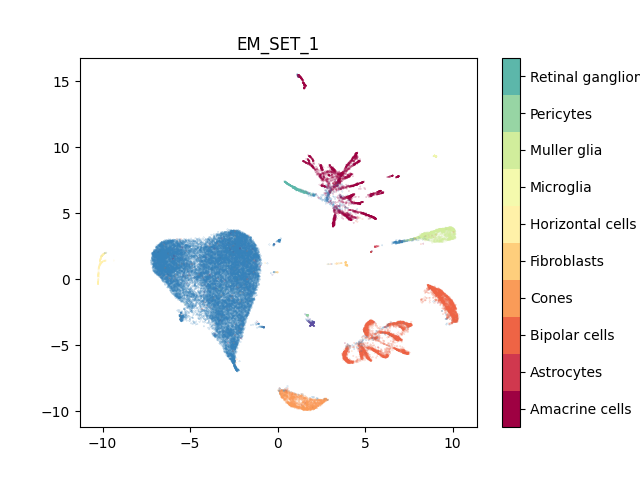

(17404, 2)


<IPython.core.display.Javascript object>


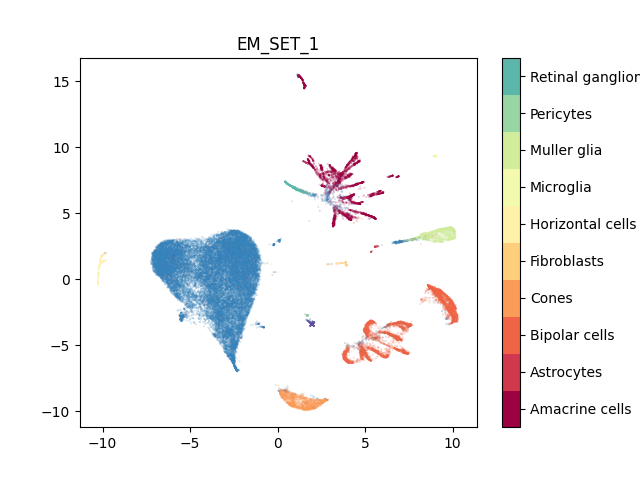

(17404, 2)


In [9]:
emb_set1 = np.concatenate((embA, embB, embC))
y_emb_set1 = np.concatenate((y_SETA, y_SETB, y_SETC))


plt.figure()
plt.title('EM_SET_1')
print(embC.shape)
plt.scatter(emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

emb_set2 = np.concatenate((embA_C, embB, embC))
y_emb_set2 = np.concatenate((y_SETA, y_SETB, y_SETC))


plt.figure()
plt.title('EM_SET_1')
print(embC.shape)
plt.scatter(emb_set2[:,0], emb_set2[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [10]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val


In [16]:
with open('MACOSKO_AlignedUMAP.npy', 'wb') as f:
    np.save(f, embA)
    np.save(f, embA_C)
    np.save(f, embB)
    np.save(f, embC)